# MLSP ASSIGNMENT 3

## SAI PRASAD PARSA

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import cv2
import librosa
import pandas as pd
import scipy
import cmath
import sys
from sklearn.decomposition import PCA
import IPython.display as ipd


### Question 1

In [64]:
from scipy.io import wavfile
file=[]
for i in range(1,21):
    file .append(librosa.load('x_ica_'+str(i)+'.wav',sr=16000)[0])
data=np.vstack(file)

In [65]:
np.asarray(data).shape

(20, 76800)

In [66]:
data_mean = np.mean(data)
centered_data = data-data_mean

In [67]:
np.linalg.eig(np.cov(centered_data))[0]

array([1.90443363e-01, 3.01367369e-02, 1.31554223e-02, 5.70160938e-03,
       7.57146051e-11, 7.59379705e-11, 7.93353367e-11, 7.91243580e-11,
       7.63221976e-11, 7.65418201e-11, 7.68670094e-11, 7.86620199e-11,
       7.85670376e-11, 7.84350415e-11, 7.83073155e-11, 7.80265468e-11,
       7.71023212e-11, 7.72916772e-11, 7.74496717e-11, 7.76386071e-11])

We retain the dimensions based on their eigen values, they tell us about the varience of the data. The eigen vector with higher eigen value is a principal component. By observing the eigen values we see that only 4 features are worth considering

In [68]:
data = data.T
pca = PCA(n_components = 4,whiten=True)
Z = pca.fit_transform(data)

In [69]:
Z = np.transpose(Z)
print(Z.shape)

(4, 76800)


In [70]:
for z in Z:
    ipd.display(ipd.Audio(z, rate = 16000))

In [71]:
W = np.identity(4)
Y = np.dot(W,Z)

In [72]:
change=[]
cond=1
while cond:
#for m in range(1000):
    old_w = W
    delW = np.multiply((76800*np.identity(4)-np.dot(np.tanh(Y),np.power(Y,3).T)),W)
    W = W + 1e-7 * delW
    Y = np.dot(W,Z)
    change.append(np.sum(np.abs(old_w)-np.abs(W)))
    cond=change[-1]
    

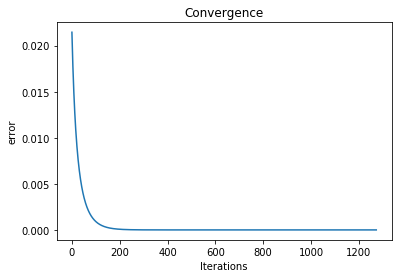

In [73]:
plt.plot(change)
plt.title('Convergence')
plt.xlabel('Iterations')
plt.ylabel('error')
plt.show()

In [74]:
print(Y)

[[ 0.01676678 -0.29608365  0.02821441 ... -0.15868335 -0.10696864
  -0.15038169]
 [ 0.01615412 -0.07119275  0.70816006 ... -0.71994155 -0.6340759
  -0.65144397]
 [-0.02981811  0.38093298 -0.54678486 ... -0.05974215 -0.02809653
   0.07695696]
 [-0.00520821  0.10550519  0.01607869 ...  0.34688408  0.42457255
   0.51898575]]


In [75]:
for i in Y:
     ipd.display(ipd.Audio(i, rate = 16000))#separated audio files

## Question 2

In [76]:
from scipy.io import wavfile

s,f1 = librosa.load('piano.wav',sr=16000)# laoding data
S=librosa.stft(s, n_fft=1024, hop_length=512,window='hann')

n,f2 = librosa.load('ocean.wav',sr=16000)
N=librosa.stft(n, n_fft=1024, hop_length=512,window='hann')


In [77]:
ipd.Audio(s, rate = 16000)

In [78]:
ipd.Audio(n, rate = 16000)

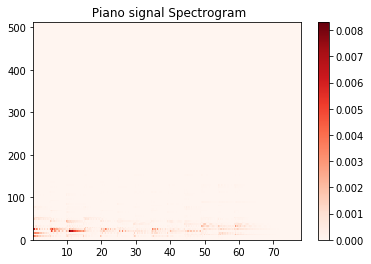

In [79]:
f, t, Sxx = scipy.signal.spectrogram(s, fs=1024)
plt.pcolormesh(t, f, Sxx,cmap='Reds')
plt.title(" Piano signal Spectrogram")
plt.colorbar()
plt.show()

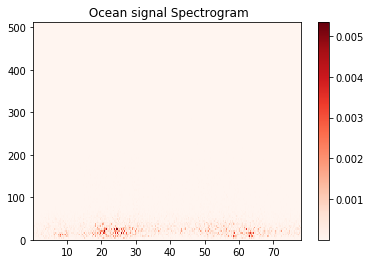

In [80]:
f, t, Sxx = scipy.signal.spectrogram(n, fs=1024)
plt.pcolormesh(t, f, Sxx,cmap='Reds')
plt.title(" Ocean signal Spectrogram")
plt.colorbar()
plt.show()

In [81]:
# S = np.real(S)
# N = np.real(N)
X = S+N
print(X.shape)

(513, 157)


In [82]:
M = np.divide(S,S+N)

In [83]:
S = np.multiply(M,X)

### IDEAL MASK

In [84]:
#calculating non-negative real valued masking matrix
S_nnreal = np.power(np.abs(np.real(S)),2)
N_nnreal = np.power(np.abs(np.real(N)),2)
M_bar = S_nnreal/(S_nnreal+N_nnreal)

In [85]:
S1 = np.multiply(M_bar,X)

In [86]:
#inverse stft
out=librosa.istft(S1,hop_length=512,length=len(s))
print(out.shape)

(80000,)


In [87]:
ipd.Audio(out, rate = 16000)

In [88]:
def SNR(s,S1):
    num=np.power(np.sum(s),2)
    num = 0
    den=0
    for t in range(len(S1)):
        num = num+s[t]**2
        den = den+(s[t] - S1[t])**2
        
    snr= (10*np.log10(num/den))
    return snr
   

In [89]:
SNR(s,out)#Ideal Mask snr

6.033105248456049

###  IBM Mask

In [90]:
B = np.zeros((X.shape[0],X.shape[1]))
for i in range (X.shape[0]):
    for j in range (X.shape[1]):
        if(np.abs(S[i][j])>np.abs(N[i][j])):
            B[i][j]=1
print(B.shape)

(513, 157)


In [91]:
S_ibm = B*X

In [92]:
out_ibm=librosa.istft(S_ibm,hop_length=512,length=len(s))

In [93]:
ipd.Audio(out_ibm, rate = 16000)

In [94]:
SNR(s,out_ibm)#SNR for IBM Mask

7.37535927741385

### Question 3

In [95]:
from scipy.io import wavfile

s,f1 = librosa.load('trs.wav',sr=16000)
S=librosa.stft(s, n_fft=1024, hop_length=512,window='hann')


In [96]:
ipd.Audio(s, rate = 16000)

In [97]:
S.shape

(513, 989)

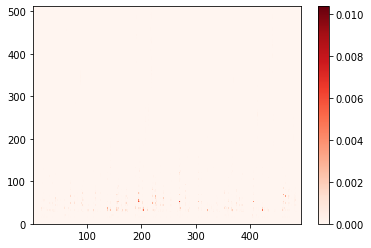

In [98]:
f, t, Sxx = scipy.signal.spectrogram(s, fs=1024)
plt.pcolormesh(t, f, Sxx,cmap='Reds')
plt.colorbar()
plt.show()

In [99]:
S=np.abs(S)

In [100]:
S.shape

(513, 989)

In [101]:
Ws = np.ones([S.shape[0],30])

In [102]:
Hs = np.ones([30,S.shape[1]])

In [103]:
old_cost = np.trace(np.dot((S - np.dot(Ws,Hs)).T,(S - np.dot(Ws,Hs))))
cond=1
while cond>1e-5:
    Ws = Ws * (np.dot(S,Hs.T))/np.dot(Ws,np.dot(Hs,Hs.T))
    Hs = Hs * (np.dot(Ws.T,S))/np.dot(Ws.T,np.dot(Ws,Hs))
    cost = np.trace(np.dot((S - np.dot(Ws,Hs)).T,(S - np.dot(Ws,Hs))))
    cond = cost-old_cost

In [104]:
n,f1 = librosa.load('trn.wav',sr=16000)
N=librosa.stft(s, n_fft=1024, hop_length=512,window='hann')


In [105]:
ipd.Audio(n, rate = 16000)

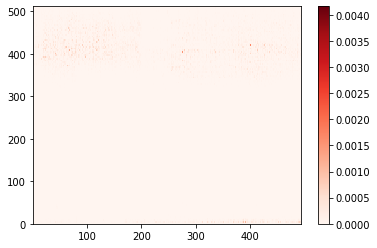

In [106]:
f, t, Sxx = scipy.signal.spectrogram(n, fs=1024)
plt.pcolormesh(t, f, Sxx,cmap='Reds')
plt.colorbar()
plt.show()

In [107]:
N=np.abs(N)

In [108]:
Wn = np.ones([N.shape[0],30])

In [109]:
Hn = np.ones([30,N.shape[1]])

In [110]:
old_cost = np.trace(np.dot((N - np.dot(Wn,Hn)).T,(N - np.dot(Wn,Hn))))
cond=1
while cond > 1e-5:
    Wn = Wn * (np.dot(N,Hn.T))/np.dot(Wn,np.dot(Hn,Hn.T))
    Hn = Hn * (np.dot(Wn.T,N))/np.dot(Wn.T,np.dot(Wn,Hn))
    cost = np.trace(np.dot((N - np.dot(Wn,Hn)).T,( N - np.dot(Wn,Hn))))
    cond= cost-old_cost

In [111]:
x,f1 = librosa.load('x_nmf.wav',sr=16000)
X=librosa.stft(x, n_fft=1024, hop_length=512,window='hann')


In [112]:
ipd.Audio(x, rate = 16000)

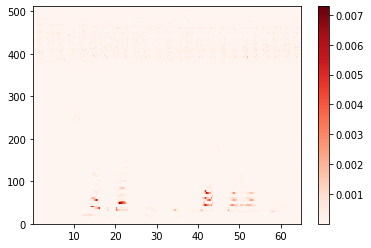

In [113]:
f, t, Sxx = scipy.signal.spectrogram(x, fs=1024)
plt.pcolormesh(t, f, Sxx,cmap='Reds')
plt.colorbar()
plt.show()

In [114]:
Y=np.abs(X)
Y.shape


(513, 131)

In [115]:
H = np.ones([60,Y.shape[1]])

In [116]:
W = np.concatenate((Ws,Wn),axis=1)
cond=1
old_cost = np.trace(np.dot((Y - np.dot(W,H)).T,(Y - np.dot(W,H))))
while  (cond)>1e-5 :
   
    H = H * (np.dot(W.T,Y))/np.dot(W.T,np.dot(W,H))
    cost = np.trace(np.dot((Y - np.dot(W,H)).T,(Y - np.dot(W,H))))
    cond= cost - old_cost

In [117]:
X_phase = X/Y

In [118]:
X_phase.shape

(513, 131)

In [119]:
o=librosa.istft(X*X_phase,hop_length=512,length=len(x))

In [120]:
ipd.Audio(o, rate = 16000)# recovered signal

In [121]:
num=np.dot(Ws,H[:30][:])
den=np.dot(Ws,H[:30][:])+np.dot(Wn,H[30:][:])
#den=np.dot(W,H)

In [122]:
mask = num/den #magnitude masking matrix

In [123]:
S_rec=mask*X

In [124]:
rec=librosa.istft(S_rec,hop_length=512,length=len(x))

In [125]:
ipd.Audio(rec, rate = 16000)#recovered speech source using magnitude masking

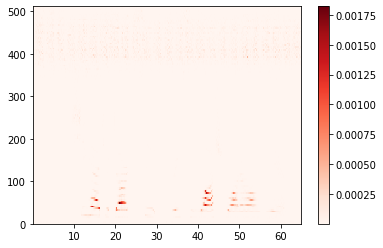

In [126]:
f, t, Sxx = scipy.signal.spectrogram(rec, fs=1024)
plt.pcolormesh(t, f, Sxx,cmap='Reds')
plt.colorbar()
plt.show()

In my view speech source recovered from magintud emasking will have higher snr.

## 4 Motor imagery

In [127]:
eeg = scipy.io.loadmat('eeg.mat')

In [128]:
eeg.keys()

dict_keys(['__header__', '__version__', '__globals__', 'x_te', 'x_train', 'y_te', 'y_train'])

In [129]:
X_test= eeg['x_te']
X_train=eeg['x_train']
y_test=eeg['y_te']
y_train=eeg['y_train']



In [130]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(768, 3, 112)
(768, 3, 28)
(112, 1)
(28, 1)


In [131]:
def prepare_data_matrix(S):
    data = np.array([]).reshape(255,0)

    for i in range(S.shape[2]):

        sample = np.array([]).reshape(0,1)

        sample1 = librosa.stft(S[:,0,i], n_fft=64, hop_length=48,window='blackman')
        sample1 = sample1[3:8, :].reshape(85,1)
        sample = np.vstack((sample,sample1))

        sample2 = librosa.stft(S[:,1,i], n_fft=64, hop_length=48,window='blackman')
        sample2 = sample2[3:8, :].reshape(85,1)
        sample = np.vstack((sample,sample2))

        sample3 = librosa.stft(S[:,2,i], n_fft=64, hop_length=48,window='blackman')
        sample3= sample3[3:8, :].reshape(85,1)
        sample = np.vstack((sample,sample3))

        data = np.hstack((data,sample))
    
    return data

In [132]:
X_train = prepare_data_matrix(X_train)
print(X_train.shape)
X_test= prepare_data_matrix(X_test)
print(X_test.shape)


(255, 112)
(255, 28)


In [133]:
def NMF(S,r):
    S=abs(S)
    W = abs(np.random.rand(S.shape[0],r))
    H = abs(np.random.rand(r,S.shape[1]))
    cond = 1
    old_cost = np.trace(np.dot((S - np.dot(W,H)).T,(S - np.dot(W,H))))
    while  cond >1e-5 :
        W = W * (np.dot(S,H.T))/np.dot(W,np.dot(H,H.T))
        H = H * (np.dot(W.T,S))/np.dot(W.T,np.dot(W,H))
        cost= np.trace(np.dot((S - np.dot(W,H)).T,(S - np.dot(W,H))))
        cond= cost - old_cost
        old_cost=cost
   # print(H)
    return H


In [134]:
def knn(train, test_sample, k):
    distances = []
    for row in range(train.shape[0]):
        dist = np.linalg.norm(train[row]-test_sample)
        distances.append((row, dist))
    distances=sorted(distances,key=lambda x: x[1])
    neighbors = list()
    #print(distances)
    for i in range(k):
        neighbors.append(distances[i][0])
     #   print(neighbors)
    return neighbors

In [135]:
def accuracy_score(y_test, predicted):
    predicted = np.asarray(predicted).reshape(28,1)
    correct=len(np.where(y_test==predicted)[0])
    accuracy = (correct/y_test.shape[0])*100
    return accuracy
    

In [136]:
ranks = [2,4,6,8,10,15,20]
N = [3,7,15]
accuracy=[]
for rank in ranks:
    H_train = NMF(X_train,rank).T
    H_test = NMF(X_test,rank).T

    for k in N:
        predictions = []
        for t in range(H_test.shape[0]):
            neighbors = knn(H_train,H_test[t],k)  
            
            y_pred = []
            for n in neighbors:
                y_pred.append(y_train[n][0])
            predictions.append(max(set(y_pred), key=y_pred.count))

        accuracy.append([rank,k,accuracy_score(y_test,predictions)])
df=pd.DataFrame(accuracy)
df.columns = ['RANK', 'K', "ACCURACY"]

        

In [874]:
df

RANK   K   ACCURACY
0      2   3  60.714286
1      2   7  53.571429
2      2  15  53.571429
3      4   3  50.000000
4      4   7  53.571429
5      4  15  39.285714
6      6   3  39.285714
7      6   7  35.714286
8      6  15  46.428571
9      8   3  57.142857
10     8   7  57.142857
11     8  15  53.571429
12    10   3  78.571429
13    10   7  67.857143
14    10  15  78.571429
15    15   3  57.142857
16    15   7  50.000000
17    15  15  60.714286
18    20   3  35.714286
19    20   7  46.428571
20    20  15  35.714286

The results here are similar to results in the lecture, we can observe that the accuracy increase as we increase the number of neighbours and then starts decreasing again.
The highest accuracy I recorded is for rank 10 k 15 with an accuracy of 78%